TODO

- Monthly Preprocessing: Date column contain M/YY instead of MM, Extract last n months to visualise (define parameter)
- Concatenate different years

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import datetime

In [44]:
df = pd.read_csv('track_2022.csv')
df

,User,Email,Client,Project,Task,Description,Billable,Start date,Start time,End date,End time,Duration,Tags,Amount ()
0,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,,No,2022-01-03,17:39:37,2022-01-03,17:53:45,00:14:08,NaN,NaN
1,Johnspinkles,johnspinkles@gmail.com,NaN,Applied Data Science,NaN,,No,2022-01-04,15:15:58,2022-01-04,15:19:44,00:03:46,NaN,NaN
2,Johnspinkles,johnspinkles@gmail.com,NaN,Applied Data Science,NaN,,No,2022-01-04,15:24:06,2022-01-04,16:40:39,01:16:33,NaN,NaN
3,Johnspinkles,johnspinkles@gmail.com,NaN,Applied Data Science,NaN,,No,2022-01-04,17:17:42,2022-01-04,17:21:43,00:04:01,NaN,NaN
4,Johnspinkles,johnspinkles@gmail.com,NaN,Applied Data Science,NaN,,No,2022-01-04,19:16:30,2022-01-04,19:47:51,00:31:21,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-09-27,21:27:15,2022-09-27,21:38:47,00:11:32,NaN,NaN
1732,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-09-27,21:56:26,2022-09-27,22:06:30,00:10:04,NaN,NaN
1733,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-09-27,22:17:11,2022-09-27,22:22:19,00:05:08,NaN,NaN
1734,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,Chores,No,2022-09-27,22:27:57,2022-09-27,22:30:59,00:03:02,NaN,NaN


### 🔴 Initial Preprocessing

In [45]:
# Drop redundant fields
df = df.drop(['User', 'Email', 'Client', 'Billable', 'Amount ()'], axis=1)

# Convert duration string to hours (float)
df['Duration']=pd.to_timedelta(df['Duration']).astype('timedelta64[s]').astype(int) / 3600
df = df.rename(columns={'Duration': 'Duration (hrs)'})

# Combine date
df['Start'] = pd.to_datetime(df['Start date'] + ' ' + df['Start time'], yearfirst=True)
df['End'] = pd.to_datetime(df['End date'] + ' ' + df['End time'], yearfirst=True)

# Drop nans in project. Uncomment these lines to explore nans
# print('NANs in PROJECT: ')
# display(df[df.Project.isna()])
df = df[df.Project.notna()]

# TODO: Remove this after testing and when you have more data. Removes out old projects
#df = df[(df.Project != 'Applied Data Science') & (df.Project != 'Statistics for Data Science') & (df.Project != 'Machine Learning 1') & (df.Project != 'MSc Project') & (df.Project != 'ML2') & (df.Project != 'BML') & (df.Project != 'Reinforcement Learning')]
df['Project'].replace('Applied Data Science', 'Data Science', inplace=True)
df['Project'].replace('Statistics for Data Science', 'Data Science', inplace=True)
df['Project'].replace('Machine Learning 1', 'Data Science', inplace=True)
df['Project'].replace('MSc Project', 'Data Science', inplace=True)
df['Project'].replace('ML2', 'Data Science', inplace=True)
df['Project'].replace('BML', 'Data Science', inplace=True)
df['Project'].replace('Reinforcement Learning', 'Data Science', inplace=True)


df

,Project,Task,Description,Start date,Start time,End date,End time,Duration (hrs),Tags,Start,End
0,To-Do,NaN,,2022-01-03,17:39:37,2022-01-03,17:53:45,0.235556,NaN,2022-01-03 17:39:37,2022-01-03 17:53:45
1,Data Science,NaN,,2022-01-04,15:15:58,2022-01-04,15:19:44,0.062778,NaN,2022-01-04 15:15:58,2022-01-04 15:19:44
2,Data Science,NaN,,2022-01-04,15:24:06,2022-01-04,16:40:39,1.275833,NaN,2022-01-04 15:24:06,2022-01-04 16:40:39
3,Data Science,NaN,,2022-01-04,17:17:42,2022-01-04,17:21:43,0.066944,NaN,2022-01-04 17:17:42,2022-01-04 17:21:43
4,Data Science,NaN,,2022-01-04,19:16:30,2022-01-04,19:47:51,0.522500,NaN,2022-01-04 19:16:30,2022-01-04 19:47:51
...,...,...,...,...,...,...,...,...,...,...,...
1731,To-Do,NaN,*,2022-09-27,21:27:15,2022-09-27,21:38:47,0.192222,NaN,2022-09-27 21:27:15,2022-09-27 21:38:47
1732,To-Do,NaN,*,2022-09-27,21:56:26,2022-09-27,22:06:30,0.167778,NaN,2022-09-27 21:56:26,2022-09-27 22:06:30
1733,To-Do,NaN,*,2022-09-27,22:17:11,2022-09-27,22:22:19,0.085556,NaN,2022-09-27 22:17:11,2022-09-27 22:22:19
1734,To-Do,NaN,Chores,2022-09-27,22:27:57,2022-09-27,22:30:59,0.050556,NaN,2022-09-27 22:27:57,2022-09-27 22:30:59


In [46]:
print('Unique Projects: ')
for i in range(df.Project.unique().shape[0]):
    print('-', df.Project.unique()[i])

Unique Projects: 
- To-Do
- Data Science
- Notes


### 🔴 Monthly Preprocessing

In [47]:
df_monthly = df.copy()
df_monthly = df_monthly.rename(columns={'Start': 'Date'})
df_monthly = df_monthly.groupby([df_monthly['Date'].dt.to_period('M'), 'Project']).sum()
df_monthly = df_monthly.reset_index()
df_monthly = df_monthly.drop(['Task', 'Tags'], axis=1)
df_monthly['Date'] = df_monthly['Date'].dt.strftime('%b %y')

df_monthly.head(10)

,Date,Project,Duration (hrs)
0,Jan 22,Data Science,25.440556
1,Jan 22,Notes,2.860833
2,Jan 22,To-Do,13.160278
3,Feb 22,Data Science,18.232222
4,Feb 22,Notes,1.210556
5,Feb 22,To-Do,24.576944
6,Mar 22,Data Science,73.550278
7,Mar 22,Notes,2.017222
8,Mar 22,To-Do,7.929722
9,Apr 22,Data Science,35.236111


### 🔴 Monthly Breakdown (Total - Academic - Other)
**Academic**
- Notes
- Data Science

**Other**
- To-Do
- Piano
- Workout

In [48]:
df_monthly_acad_other = df_monthly.copy()
df_monthly_acad_other['Project'].replace('Data Science', 'Academic', inplace=True)
df_monthly_acad_other['Project'].replace('Notes', 'Academic', inplace=True)
df_monthly_acad_other['Project'].replace('To-Do', 'Other', inplace=True)
df_monthly_acad_other['Project'].replace('Piano', 'Other', inplace=True)
df_monthly_acad_other['Project'].replace('Workout', 'Other', inplace=True)

# All
df_monthly_total = df_monthly.copy()
for project in df_monthly_total.Project.unique():
    df_monthly_total['Project'].replace(project, 'All', inplace=True)
df_monthly_total = df_monthly_total.groupby('Date', sort=False).sum()
df_monthly_total.reset_index(inplace=True)

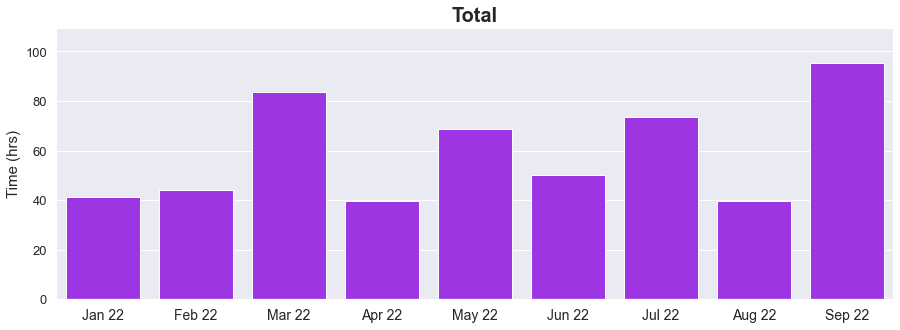

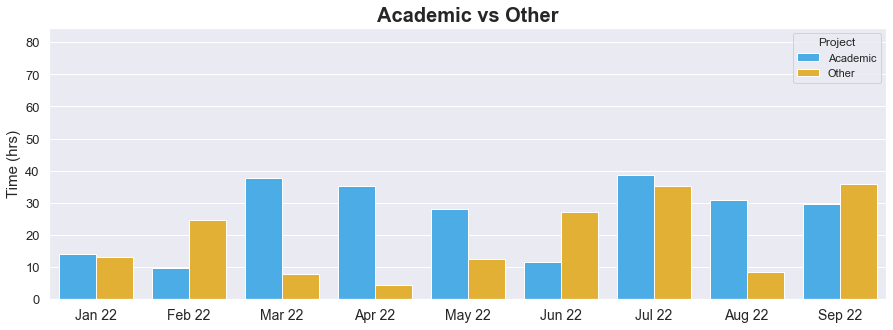

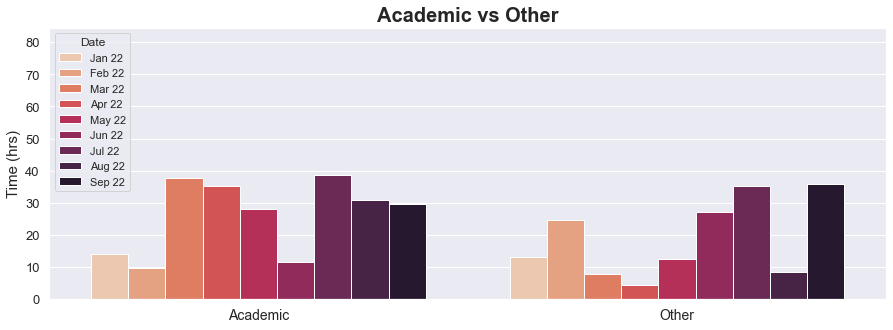

In [49]:
figsize=(15,5)
legendsize=10
title_size=20
title='Total'
bar_label_size=17
x_tick_size = 14
y_tick_size = 13

sns.set_theme(style='darkgrid')
plt.figure(figsize=figsize)

y_lim = df_monthly_total['Duration (hrs)'].max() + df_monthly_total['Duration (hrs)'].max() * 0.15



# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 
          'Academic': "#33B2FF"}
hue_order = ['Academic', 'Other']


ax = sns.barplot(x='Date', y='Duration (hrs)', data=df_monthly_total, color='#A418FF', ci=None)
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars

plt.show()













title='Academic vs Other'


y_lim = df_monthly_acad_other['Duration (hrs)'].max() + df_monthly_acad_other['Duration (hrs)'].max() * 0.15

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 
          'Academic': "#33B2FF"}
hue_order = ['Academic', 'Other']


ax = sns.barplot(x='Date', y='Duration (hrs)', data=df_monthly_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order)
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars

plt.show()














title='Academic vs Other'
sns.set_palette(sns.color_palette("rocket_r"))
#sns.set_palette(sns.dark_palette("#69d", reverse=True, as_cmap=True))

y_lim = df_monthly_acad_other['Duration (hrs)'].max() + df_monthly_acad_other['Duration (hrs)'].max() * 0.15

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 'Academic': "#33B2FF"}


ax = sns.barplot(x='Project', y='Duration (hrs)', data=df_monthly_acad_other, hue='Date', ci=None, palette = 'rocket_r')
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars

plt.show()

### 🔴 Monthly Breakdown (Individual Projects)

In [50]:
df_monthly

,Date,Project,Duration (hrs)
0,Jan 22,Data Science,25.440556
1,Jan 22,Notes,2.860833
2,Jan 22,To-Do,13.160278
3,Feb 22,Data Science,18.232222
4,Feb 22,Notes,1.210556
5,Feb 22,To-Do,24.576944
6,Mar 22,Data Science,73.550278
7,Mar 22,Notes,2.017222
8,Mar 22,To-Do,7.929722
9,Apr 22,Data Science,35.236111


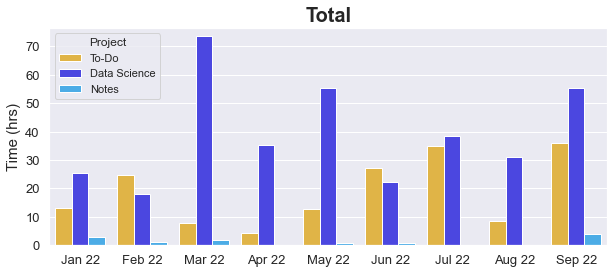

In [51]:
figsize=(10,4)
legendsize=10
title_size=20
bar_label_size=17
x_tick_size = 13
y_tick_size = 13

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/
unique_projects = df_monthly.Project.unique().shape[0]

colors = {'To-Do': "#FABF2D", 
          'Notes': "#33B2FF", 
          'Data Science': "#332DFA", 
          'Piano': '0FB528', 
          'Workout': 'C01E05'}

hue_order = ['To-Do', 'Data Science', 'Notes']


ax = sns.barplot(x='Date', y='Duration (hrs)', data=df_monthly, hue='Project', ci=None, palette=colors, hue_order=hue_order)
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title('Total', fontsize=title_size, fontweight='bold')
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold', label_type='center') # Show values above bars
plt.ylim([0, df_monthly['Duration (hrs)'].max() + 3])     # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks

plt.show()

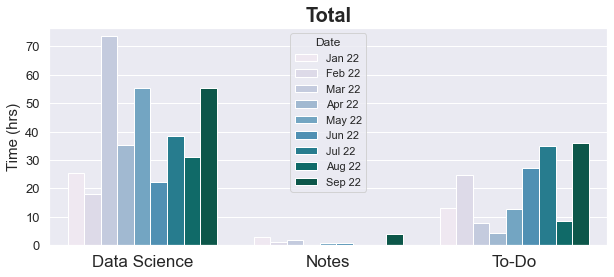

In [52]:
## figsize=(12,4)
legendsize=10
title_size=20
bar_label_size=17

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

ax = sns.barplot(x='Project', y='Duration (hrs)', data=df_monthly, hue='Date', ci=None, palette='PuBuGn')
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title('Total', fontsize=title_size, fontweight='bold')
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold', label_type='center') # Show values above bars
plt.ylim([0, df_monthly['Duration (hrs)'].max() + 3])     # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=17)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=13)                         # Enlarge x ticks

plt.show()

### 🔴 Annual Breakdown